<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S6/MNIST_Assignment6-withL1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install the dependencies


In [2]:
!pip install torchsummary

### Import dependencies

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm_notebook as tqdm
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from torch.optim.lr_scheduler import StepLR

### Helper utilities

In [24]:
def isCuda():
  return torch.cuda.is_available()

def randInt(min, max, size): 
  return torch.LongTensor(size).random_(min, max)

def getDevice(): 
  return torch.device("cuda" if isCuda() else "cpu")

def showImages(images, labels, cols=10): 
  figure = plt.figure()
  num_of_images = len(images)
  rows = np.ceil(num_of_images/float(cols))
  for index in range(0, num_of_images):
    plt.subplot(rows, cols, index + 1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r') 
    plt.title(labels[index].item())

cpu = torch.device("cpu")
device = getDevice()
print(f'\nDevice: {device}')

# Set seed 
seed =1 
torch.manual_seed(seed)
if isCuda():
  torch.cuda.manual_seed(seed)



Device: cuda


### Transformations for Train and Test

In [0]:
def train_transformations(): 
  return transforms.Compose([         
                    transforms.RandomRotation((-7.0, 7.0), fill=(1,)), 
                    transforms.ToTensor(), 
                    transforms.Normalize((0.1307,), (0.3081,))])
  
def test_transformations(): 
  return transforms.Compose([
                    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

### Load train and test data

In [20]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if isCuda() else dict(shuffle=True, batch_size=64)

train_data = datasets.MNIST("../data", train=True, transform=train_transformations(), download=True)
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

test_data = datasets.MNIST("../data", train=False, transform=test_transformations(), download=True)
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

print(f'\nSize of train data:{train_data.data.shape}')
print(f'\nSize of test data:{test_data.data.shape}')


Size of train data:torch.Size([60000, 28, 28])

Size of test data:torch.Size([10000, 28, 28])


### View training/test data and their statistics


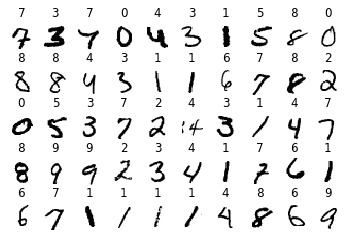

In [25]:
randImages = randInt(0, len(test_data.data), 50)
showImages(test_data.data[randImages], test_data.targets[randImages])

### Network architecture

In [8]:
class Net(nn.Module): 

  def __init__(self): 
    super(Net, self).__init__()

    drop_out = 0.04
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # RF - 3x3
        nn.ReLU(), 
        nn.BatchNorm2d(10),
        nn.Dropout2d(drop_out),
        nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # RF - 5x5
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(drop_out)
    ) # Output - 24 x 24

    self.transition1 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False), # RF - 5x5
        nn.MaxPool2d(2, 2), # # RF - 6x6
    ) # Output - 12 x 12

    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # RF - 10x10
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(drop_out),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # RF - 14x14
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(drop_out),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # RF - 18x18
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(drop_out),
        nn.Conv2d(in_channels=16, out_channels=15, kernel_size=(3, 3), padding=0, bias=False), # RF - 22x22
        nn.ReLU()
    ) # output = 4 x 4

    self.gap1 = nn.AdaptiveAvgPool2d(1) # RF - 28x28
    self.conv4 = nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), bias=False) # RF - 28x28

  def forward(self, x): 

    x = self.transition1(self.conv1(x))
    x = self.conv2(x)
    x = self.conv4(self.gap1(x))
    x = x.view(-1, 10)
    return F.log_softmax(x)

  def summarize(self, input): 
    summary(self, input_size=input)

Net().to(getDevice()).summarize((1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,440
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         Dropout2d-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
        Dropout2d-14           [-1, 16,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


### Utilities to compute metrics

In [0]:
def compute_accuracy(prediction, target): 
  return 100 * prediction.eq(target.view_as(prediction)).sum().item() / float(len(prediction))

def compute_miss(data, prediction, target): 
  corrects = prediction.eq(target.view_as(prediction))
  accuracy = corrects.sum().item() / len(prediction)
  miss_indices = ~corrects
  miss_data = data[miss_indices]  
  miss_predictions = prediction[miss_indices]
  miss_targets = target[miss_indices]
  print(confusion_matrix(target.to(cpu), prediction.to(cpu)))
  return (miss_data, miss_predictions, miss_targets)

### Code to train the model

In [0]:
factor = 0.0005

def compute_L1(model): 
  allWeights = torch.cat([x.view(-1) for x in model.parameters()])
  loss = torch.norm(allWeights, 1)
  return loss

def compute_L2(model): 
  allWeights = torch.cat([x.view(-1) for x in model.parameters()])
  loss = torch.norm(allWeights, 2)
  return loss

def train_one_batch(model, data, target, optimizer): 
  optimizer.zero_grad()
  output = model(data)
  loss = F.nll_loss(output, target) + factor * compute_L1(model)
  loss.backward()
  optimizer.step()
  return (loss, output.argmax(dim=1))

def train_one_epoch(model, train_loader, optimizer, device=getDevice()): 
  model.train()
  pbar = tqdm(train_loader, ncols=1000) 
  wholePred = []
  wholeData = []
  wholeTarget = []
  totalLoss = 0
  for idx, (data, target) in enumerate(pbar): 
    data, target = data.to(device), target.to(device)
    (loss, prediction) = train_one_batch(model, data, target, optimizer)
    accuracy = compute_accuracy(prediction, target)
    wholePred.append(prediction)
    wholeData.append(data)
    wholeTarget.append(target)
    totalLoss += loss
  return (torch.cat(wholeData), torch.cat(wholeTarget), torch.cat(wholePred), totalLoss/len(train_loader.dataset))

### Code to test the model

In [0]:
def test_one_batch(model, data, target): 
  output = model(data)
  loss = F.nll_loss(output, target)  
  return (loss, output.argmax(dim=1))
  
def test(model, test_loader, device=getDevice()): 
  model.eval()
  pbar = tqdm(test_loader, ncols=1000)
  wholePred = []
  wholeData = []
  wholeTarget = []
  totalLoss = 0
  with torch.no_grad(): 
    for idx, (data, target) in enumerate(pbar): 
      data, target = data.to(device), target.to(device)
      (loss, prediction) = test_one_batch(model, data, target)
      totalLoss += loss
      accuracy = compute_accuracy(prediction, target)
      wholePred.append(prediction)
      wholeData.append(data)
      wholeTarget.append(target)
  return (torch.cat(wholeData), torch.cat(wholeTarget), torch.cat(wholePred), totalLoss/len(test_loader.dataset))

### Build the model by training and testing. 

In [43]:
def build(model, train_loader, optimizer, epoch, scheduler):
  train_accs = []
  train_losses = []
  test_accs = [] 
  test_losses = []
  for e in range(0, epoch): 
    print(f'\n\nEpoch: {e + 1}')
    (train_data, train_target, train_prediction, avgTrainLoss) = train_one_epoch(model, train_loader, optimizer)
    trainAcc = compute_accuracy(train_prediction, train_target)
    train_accs.append(trainAcc)
    train_losses.append(avgTrainLoss)
    print(f'Train Accuracy: {trainAcc}%, Train Loss: {avgTrainLoss}')
    (test_data, test_target, test_prediction, avgTestLoss) = test(net, test_loader)
    testAcc = compute_accuracy(test_prediction, test_target)
    test_accs.append(testAcc)
    test_losses.append(avgTestLoss)
    print(f'Test Accuracy: {testAcc}%, Test Loss: {avgTestLoss}')
    scheduler.step()
  return(train_accs, train_losses, test_accs, test_losses)

net = Net().to(getDevice())
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
(train_accs, train_losses, test_accs, test_losses) = build(net, train_loader, optimizer, 40, scheduler)



Epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Accuracy: 83.77666666666667%, Train Loss: 0.006116182543337345


Test Accuracy: 97.91%, Test Loss: 0.0005841150414198637


Epoch: 2


Train Accuracy: 97.22166666666666%, Train Loss: 0.0026120804250240326


Test Accuracy: 98.33%, Test Loss: 0.0004128499422222376


Epoch: 3


Train Accuracy: 97.62833333333333%, Train Loss: 0.002273314632475376


Test Accuracy: 98.41%, Test Loss: 0.00039411737816408277


Epoch: 4


Train Accuracy: 97.73333333333333%, Train Loss: 0.0020924536511301994


Test Accuracy: 98.67%, Test Loss: 0.00034410395892336965


Epoch: 5


Train Accuracy: 97.83333333333333%, Train Loss: 0.0019981495570391417


Test Accuracy: 98.83%, Test Loss: 0.0003084094787482172


Epoch: 6


Train Accuracy: 97.97833333333334%, Train Loss: 0.0019118725322186947


Test Accuracy: 98.86%, Test Loss: 0.00032368540996685624


Epoch: 7


Train Accuracy: 97.965%, Train Loss: 0.001867663231678307


Test Accuracy: 98.84%, Test Loss: 0.0002883269335143268


Epoch: 8


Train Accuracy: 97.95166666666667%, Train Loss: 0.0018289850559085608


Test Accuracy: 98.8%, Test Loss: 0.00028847268549725413


Epoch: 9


Train Accuracy: 97.92833333333333%, Train Loss: 0.001801726990379393


Test Accuracy: 98.62%, Test Loss: 0.00037536845775321126


Epoch: 10


Train Accuracy: 98.09%, Train Loss: 0.001754195662215352


Test Accuracy: 98.87%, Test Loss: 0.00028042562189511955


Epoch: 11


Train Accuracy: 98.775%, Train Loss: 0.0015472806990146637


Test Accuracy: 99.36%, Test Loss: 0.00017005446716211736


Epoch: 12


Train Accuracy: 98.825%, Train Loss: 0.0014819098869338632


Test Accuracy: 99.37%, Test Loss: 0.00017032166942954063


Epoch: 13


Train Accuracy: 98.86%, Train Loss: 0.001435738755390048


Test Accuracy: 99.39%, Test Loss: 0.00015827218885533512


Epoch: 14


Train Accuracy: 98.85%, Train Loss: 0.0014086572919040918


Test Accuracy: 99.34%, Test Loss: 0.0001574012712808326


Epoch: 15


Train Accuracy: 98.885%, Train Loss: 0.0013879775069653988


Test Accuracy: 99.32%, Test Loss: 0.00015492238162551075


Epoch: 16


Train Accuracy: 98.85166666666667%, Train Loss: 0.0013714280212298036


Test Accuracy: 99.34%, Test Loss: 0.000166887286468409


Epoch: 17


Train Accuracy: 98.80166666666666%, Train Loss: 0.0013551810989156365


Test Accuracy: 99.31%, Test Loss: 0.00016859275638125837


Epoch: 18


Train Accuracy: 98.86833333333334%, Train Loss: 0.0013373441761359572


Test Accuracy: 99.39%, Test Loss: 0.0001552584726596251


Epoch: 19


Train Accuracy: 98.85333333333334%, Train Loss: 0.0013276214012876153


Test Accuracy: 99.38%, Test Loss: 0.00015256283222697675


Epoch: 20


Train Accuracy: 98.83166666666666%, Train Loss: 0.0013218926033005118


Test Accuracy: 99.33%, Test Loss: 0.00016815845447126776


Epoch: 21


Train Accuracy: 98.91833333333334%, Train Loss: 0.0012821733253076673


Test Accuracy: 99.38%, Test Loss: 0.00014427393034566194


Epoch: 22


Train Accuracy: 98.99%, Train Loss: 0.0012711981544271111


Test Accuracy: 99.41%, Test Loss: 0.0001478343765484169


Epoch: 23


Train Accuracy: 98.98833333333333%, Train Loss: 0.001259968732483685


Test Accuracy: 99.39%, Test Loss: 0.00014304251817520708


Epoch: 24


Train Accuracy: 98.95%, Train Loss: 0.001264998340047896


Test Accuracy: 99.45%, Test Loss: 0.0001453208678867668


Epoch: 25


Train Accuracy: 99.02166666666666%, Train Loss: 0.0012519082520157099


Test Accuracy: 99.43%, Test Loss: 0.0001430388365406543


Epoch: 26


Train Accuracy: 99.015%, Train Loss: 0.0012569428654387593


Test Accuracy: 99.46%, Test Loss: 0.0001415090955561027


Epoch: 27


Train Accuracy: 98.98%, Train Loss: 0.0012455006362870336


Test Accuracy: 99.45%, Test Loss: 0.00014110439224168658


Epoch: 28


Train Accuracy: 99.01%, Train Loss: 0.0012440892169252038


Test Accuracy: 99.45%, Test Loss: 0.0001410029799444601


Epoch: 29


Train Accuracy: 99.01666666666667%, Train Loss: 0.0012409614864736795


Test Accuracy: 99.49%, Test Loss: 0.00013984633551444858


Epoch: 30


Train Accuracy: 99.025%, Train Loss: 0.0012425035238265991


Test Accuracy: 99.47%, Test Loss: 0.00014230214583221823


Epoch: 31


Train Accuracy: 99.005%, Train Loss: 0.0012419874547049403


Test Accuracy: 99.44%, Test Loss: 0.00014583041775040329


Epoch: 32


Train Accuracy: 98.99666666666667%, Train Loss: 0.0012383665889501572


Test Accuracy: 99.44%, Test Loss: 0.0001418581377947703


Epoch: 33


Train Accuracy: 99.04833333333333%, Train Loss: 0.001229587011039257


Test Accuracy: 99.45%, Test Loss: 0.0001407513045705855


Epoch: 34


Train Accuracy: 99.03166666666667%, Train Loss: 0.0012272847816348076


Test Accuracy: 99.46%, Test Loss: 0.00014149106573313475


Epoch: 35


Train Accuracy: 99.015%, Train Loss: 0.001232868293300271


Test Accuracy: 99.42%, Test Loss: 0.00014189032663125545


Epoch: 36


Train Accuracy: 99.03%, Train Loss: 0.0012351666809991002


Test Accuracy: 99.47%, Test Loss: 0.00014242090401239693


Epoch: 37


Train Accuracy: 99.06333333333333%, Train Loss: 0.0012323088012635708


Test Accuracy: 99.46%, Test Loss: 0.00014000355440657586


Epoch: 38


Train Accuracy: 99.04833333333333%, Train Loss: 0.0012306494172662497


Test Accuracy: 99.44%, Test Loss: 0.0001415910228388384


Epoch: 39


Train Accuracy: 99.02%, Train Loss: 0.0012323785340413451


Test Accuracy: 99.45%, Test Loss: 0.0001401287008775398


Epoch: 40


Train Accuracy: 98.99333333333334%, Train Loss: 0.0012391217751428485


Test Accuracy: 99.45%, Test Loss: 0.0001403696514898911


Text(0.5, 1.0, 'Test Loss')

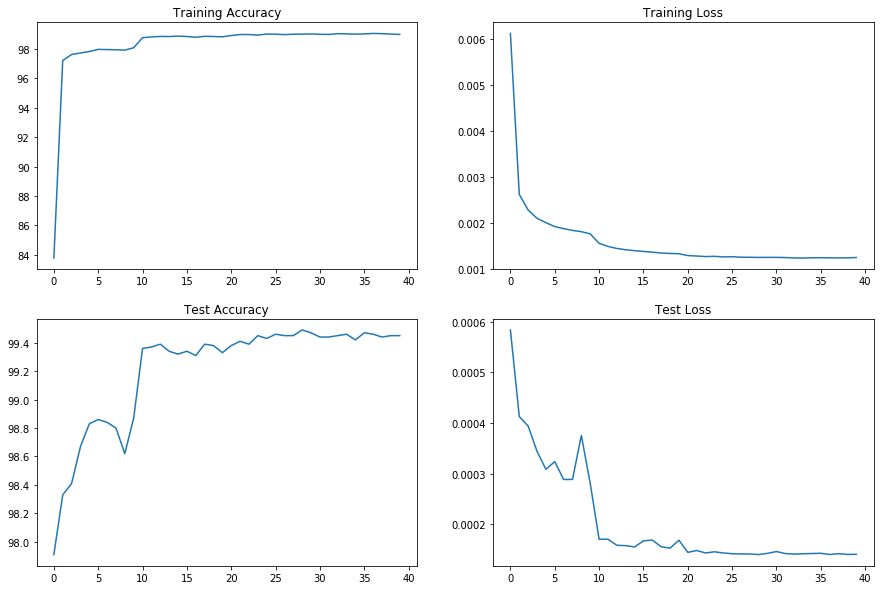

In [44]:
fig, axs = plt.subplots(2,2,figsize=(15, 10))
axs[0, 0].plot(train_accs)
axs[0, 0].set_title("Training Accuracy")
axs[0, 1].plot(train_losses)
axs[0, 1].set_title("Training Loss")
axs[1, 0].plot(test_accs)
axs[1, 0].set_title("Test Accuracy")
axs[1, 1].plot(test_losses)
axs[1, 1].set_title("Test Loss")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 979    0    0    0    0    0    0    1    0    0]
 [   0 1131    1    1    0    0    1    1    0    0]
 [   0    1 1026    0    0    0    0    4    1    0]
 [   0    0    0 1005    0    4    0    0    1    0]
 [   0    0    0    0  977    0    0    0    0    5]
 [   0    0    0    4    0  885    3    0    0    0]
 [   2    3    0    0    1    2  949    0    1    0]
 [   0    2    2    0    0    0    0 1024    0    0]
 [   0    1    1    0    0    1    0    0  970    1]
 [   0    0    0    1    6    0    0    3    0  999]]


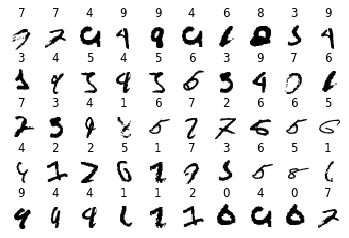

In [45]:
(test_data, test_target, test_prediction, avgTestLoss) = test(net, test_loader)
(miss_data, miss_predictions, miss_targets) = compute_miss(test_data, test_prediction, test_target)

randImages = randInt(0, len(miss_data), 50)
showImages(miss_data[randImages].to(cpu), miss_predictions[randImages].to(cpu))

In [35]:
print(compute_L1(net))

tensor(850.5319, device='cuda:0', grad_fn=<NormBackward0>)
